In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
row_first = session.query(Measurement).first()
row_first.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fb6edd2ac70>,
 'prcp': 0.08,
 'tobs': 65.0,
 'id': 1,
 'station': 'USC00519397',
 'date': '2010-01-01'}

In [26]:
for row in session.query(Measurement.id, Measurement.tobs, Measurement.date, Measurement.prcp, Measurement.station).limit(5):
    print(row)

(1, 65.0, '2010-01-01', 0.08, 'USC00519397')
(2, 63.0, '2010-01-02', 0.0, 'USC00519397')
(3, 74.0, '2010-01-03', 0.0, 'USC00519397')
(4, 76.0, '2010-01-04', 0.0, 'USC00519397')
(5, 73.0, '2010-01-06', None, 'USC00519397')


In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01',)

In [13]:
#last date in dataset 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [14]:
# Calculate the date one year from the last date in data set.
latest_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
start_date = latest_date - dt.timedelta(days=365)
print(start_date)

2016-08-23 00:00:00


In [15]:

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, 
       func.sum(Measurement.prcp)]
precipitation = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()




In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column


# Sort the dataframe by date
precip_df = pd.DataFrame(precipitation, columns=['measurement_date', 'precipitation_amount'])
precip_df.dropna(axis=0, how='any', inplace= True)
precip_df.sort_values(by='measurement_date')
precip_df.set_index('measurement_date', inplace=True)
precip_df.head()


,precipitation_amount
measurement_date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


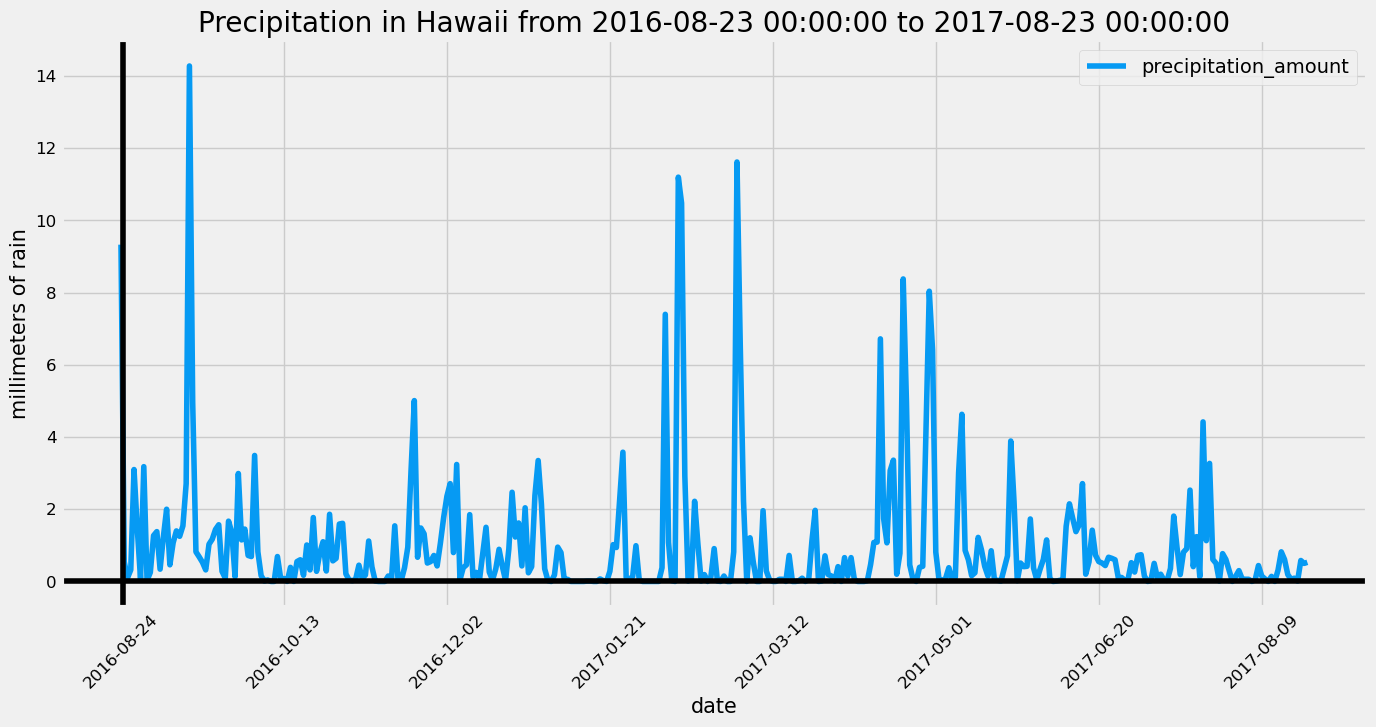

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data

precip_df.plot(figsize=(15, 7),
    sort_columns=True, 
    rot=45, 
    use_index=True, 
    title=(f'Precipitation in Hawaii from {start_date} to {latest_date}'),
    legend=True,
    fontsize=12,
    grid=True,
    color='xkcd:azure')

plt.axvline(x=0.5, color="black")
plt.axhline(color="black")
plt.xlabel('date', fontsize=15)
plt.ylabel('millimeters of rain', fontsize=15)

plt.savefig(f'Precipitation in Hawaii from {start_date} to {latest_date}')
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation_amount
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
number_of_stations = session.query(Station.name).count()
print(number_of_stations)

9


In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.date)]
active_stations = session.query(*sel).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp = engine.execute('SELECT min(tobs) FROM Measurement GROUP BY station HAVING COUNT(*) > 1 ORDER BY count(station) desc LIMIT 1')
for lowest in lowest_temp:
    print(lowest)

highest_temp = engine.execute('SELECT max(tobs) FROM Measurement GROUP BY station HAVING COUNT(*) > 1 ORDER BY count(station) desc LIMIT 1')
for highest in highest_temp:
    print(highest)
    
avg_temp = engine.execute('SELECT avg(tobs) FROM Measurement GROUP BY station HAVING COUNT(*) > 1 ORDER BY count(station) desc LIMIT 1')
for avg in avg_temp:
    print(avg)

(54.0,)
(85.0,)
(71.66378066378067,)


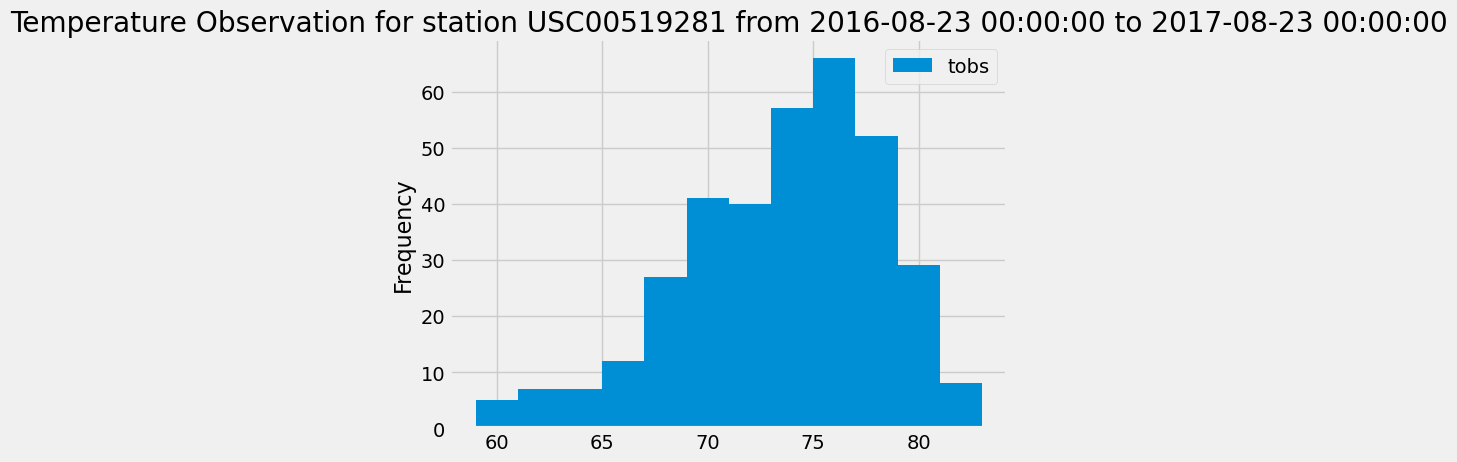

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_tobs = session.query(Measurement.tobs, Measurement.date).\
    filter(Measurement.station == "USC00519281", Measurement.date >=start_date, Measurement.date <= latest_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column and Sort the dataframe by date
last_year_station_climate_df = pd.DataFrame(most_active_station_tobs, columns=['tobs','date']).sort_values(by='date')
last_year_station_climate_df.set_index('date', inplace=True)
last_year_station_climate_df.head(12)

tobs = [temp[0] for temp in most_active_station_tobs]

# Plot
plt.hist(tobs, bins=12)
plt.title(f"Temperature Observation for station USC00519281 from {start_date} to {latest_date}")
plt.ylabel('Frequency', fontsize=16)
labels = ['tobs']

plt.legend(labels)
plt.show()

# Close session

In [23]:
# Close Session
session.close()